# PART 4: Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import emoji
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import pickle

%config InlineBackend.figure_format = 'retina'

#### _Setting up colormap for confusion matrices_

In [2]:
colors = ['#EBECF0','#b2a3af','#ff355e']  # R -> G -> B
cmap_name = 'pnkgry'
pnkgry = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

#### Retrieving data harvested in step 1, cleaned in step 2, and enhanced in step 3 from csv files to dataframes

In [3]:
AW_comments_df = pd.read_csv('../data/aw_com.csv')
AW_posts_df = pd.read_csv('../data/aw_pos.csv')
AM_comments_df = pd.read_csv('../data/am_com.csv')
AM_posts_df = pd.read_csv('../data/am_pos.csv')

## 4.1 Baseline model

In [4]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), AM_posts_df['title_selftext'].dropna(), 
               AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, random_state = 11)

In [5]:
def baseline_model(indep,dep): # time permitting, I could deploy this as a class?
    if dep.mean()> 0.5:
        prediction = np.ones_like(dep)
    else:
        prediction = np.zeros_like(dep)
    return prediction

In [6]:
print(f"The baseline model accuracy is {round(accuracy_score(y, baseline_model(X,y)), 4)}.")

The baseline model accuracy is 0.5082.


## 4.2 Classification using estimators with default parameters

### 4.2.1 Comparing results of several classifiers on just vector data

In [7]:
cvec = CountVectorizer(stop_words='english', lowercase = True, ngram_range=(1,3))#max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [8]:
models = ['xgbc', 'logreg','rfc', 'mnb','svm']
estimators = [XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'), LogisticRegression(max_iter = 10_000), RandomForestClassifier(), MultinomialNB(), SVC()]
mod_est = {model: estimator for model, estimator in zip(models, estimators)}

def fit_score_estimator(model, train_indep, train_dep, test_indep, test_dep):
    if model in models:
        model_str = model
        model = mod_est[model]
        model.fit(train_indep, train_dep)
        train_score = model.score(train_indep, train_dep)
        test_score = model.score(test_indep, test_dep)
        print(f"{model_str.capitalize()} scored {round(train_score,4)} on train data and {round(test_score,4)} on test data.")
        return train_score, test_score  
    else: 
        print(f"{model_str.capitalize()} is not a valid argument for the function. Please select a model from the 'models' list above")

In [9]:
train_scores = []
test_scores = []
for model in models:
    trsc, tssc = fit_score_estimator(model, train_X_vec, train_y, test_X_vec, test_y)
    train_scores.append(trsc)
    test_scores.append(tssc)

Xgbc scored 0.7778 on train data and 0.6614 on test data.
Logreg scored 0.9846 on train data and 0.6944 on test data.
Rfc scored 0.9923 on train data and 0.6722 on test data.
Mnb scored 0.9731 on train data and 0.7088 on test data.
Svm scored 0.8892 on train data and 0.6524 on test data.


In [10]:
train_test_scores = pd.DataFrame(np.array([train_scores, test_scores]), columns = models, index = ['train_score', 'test_score'])
train_test_scores

,xgbc,logreg,rfc,mnb,svm
train_score,0.777831,0.984575,0.992347,0.973096,0.889155
test_score,0.661406,0.694405,0.672166,0.708752,0.652439


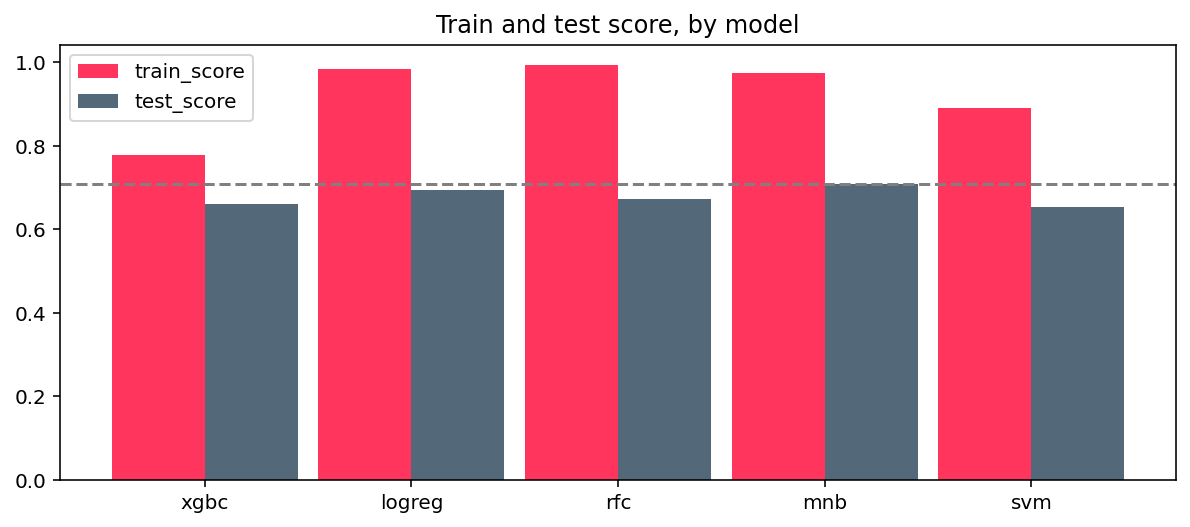

In [11]:
train_test_scores.T.plot(kind = 'bar', color = ['#ff355e','#536878'], 
                         title = 'Train and test score, by model', width = 0.9, figsize = (10, 4), rot = 0)
plt.axhline(0.709, ls = '--', color = 'grey');
plt.savefig('../visualizations/scores_bar_text.png')

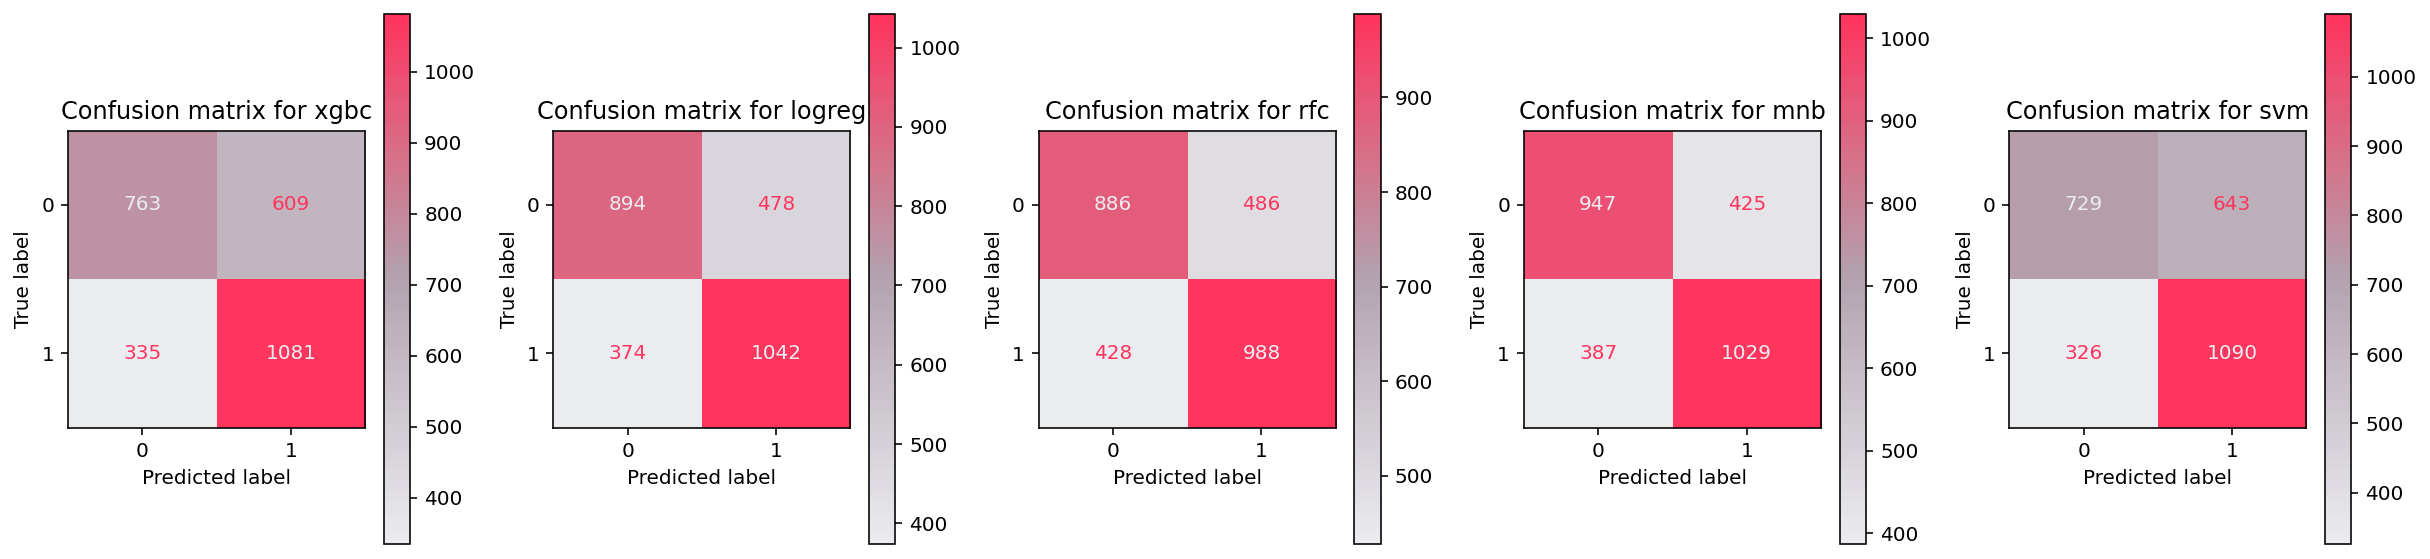

In [12]:
# would have taken me much longer without this: https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix

fig, axes = plt.subplots(1,5, figsize=(17,4))
for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(mod_est[model], test_X_vec, test_y, ax=ax, cmap=pnkgry)
    ax.title.set_text(f"Confusion matrix for {model}")
plt.tight_layout()  
plt.show()

**Multinomial Naive Bayes** performs best on just vectorized text data.

In [13]:
mnb = MultinomialNB()

params = {'alpha': np.linspace(0,1,10)}
mnb_gs = GridSearchCV(mnb, params, n_jobs = 5, verbose = 1, cv = 5)

mnb_gs.fit(train_X_vec, train_y)
print(f"Best CV score of {round(mnb_gs.best_score_,4)} achieved with alpha = {round(mnb_gs.best_params_['alpha'],4)}")
print(f"Best mnb estimator has accuracy of {round(accuracy_score(test_y,mnb_gs.best_estimator_.predict(test_X_vec)),4)} on test data.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Best CV score of 0.716 achieved with alpha = 0.8889
Best mnb estimator has accuracy of 0.7102 on test data.


[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    1.8s finished


### 4.2.2 Classifying using word vector and sentiment scores

In [9]:
AW_posts_df.dropna(subset = ['title_selftext'],inplace = True)
AW_comments_df.dropna(subset = ['body'], inplace = True)
AM_posts_df.dropna(subset = ['title_selftext'], inplace = True)
AM_comments_df.dropna(subset = ['body'],inplace = True)

In [10]:
X_cont = pd.concat([AW_posts_df['title_selftext'], AW_comments_df['body'], 
                    AM_posts_df['title_selftext'], AM_comments_df['body']], axis = 0)

X_sent = pd.concat([AW_posts_df[['sia_neg', 'sia_pos', 'senti_score']], AW_comments_df[['sia_neg', 'sia_pos', 'senti_score']],
                  AM_posts_df[['sia_neg', 'sia_pos', 'senti_score']], AM_comments_df[['sia_neg', 'sia_pos', 'senti_score']]], axis = 0)

X = pd.concat([X_cont, X_sent], axis = 1)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext']),
                    np.zeros_like(AW_comments_df['body']),
                    np.ones_like(AM_posts_df['title_selftext']),
                    np.ones_like(AM_comments_df['body'])]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 11)

tvec = TfidfVectorizer()

X_train_vec = pd.merge(pd.DataFrame(tvec.fit_transform(X_train.iloc[:,0]).todense()), X_train.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

X_test_vec = pd.merge(pd.DataFrame(tvec.transform(X_test.iloc[:,0]).todense()), X_test.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

In [16]:
train_scores = []
test_scores = []
for model in models:
    trsc, tssc = fit_score_estimator(model, X_train_vec, y_train, X_test_vec, y_test)
    train_scores.append(trsc)
    test_scores.append(tssc)

Xgbc scored 0.7699 on train data and 0.5092 on test data.
Logreg scored 0.7087 on train data and 0.5043 on test data.
Rfc scored 1.0 on train data and 0.5163 on test data.
Mnb scored 0.7158 on train data and 0.4967 on test data.
Svm scored 0.7426 on train data and 0.5125 on test data.


In [17]:
train_test_scores = pd.DataFrame(np.array([train_scores, test_scores]), columns = models, index = ['train_score', 'test_score'])
train_test_scores 

,xgbc,logreg,rfc,mnb,svm
train_score,0.769910,0.708740,1.000000,0.715835,0.742605
test_score,0.509239,0.504348,0.516304,0.496739,0.512500


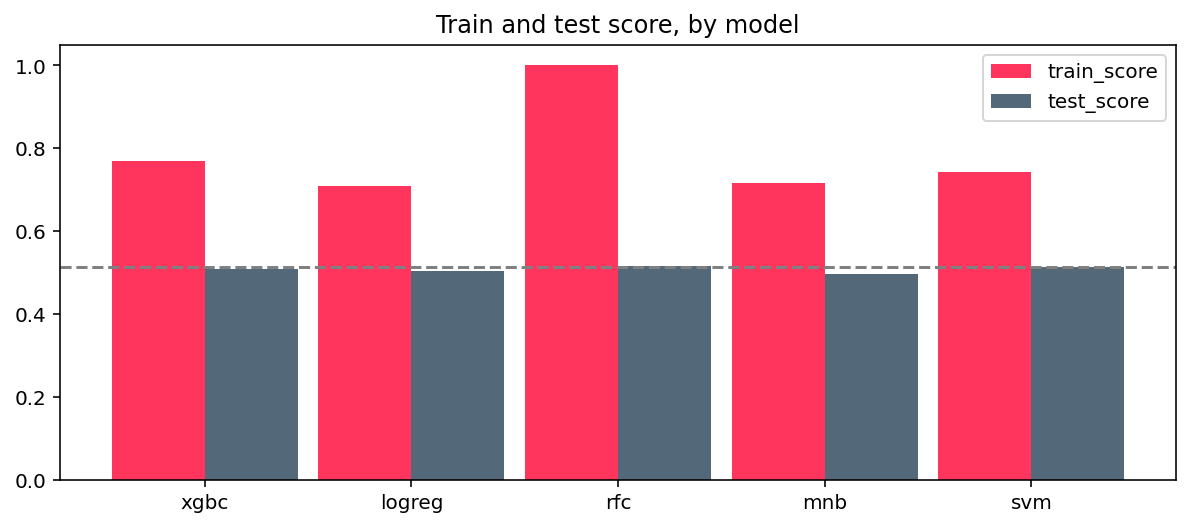

In [18]:
train_test_scores.T.plot(kind = 'bar', color = ['#ff355e','#536878'], 
                         title = 'Train and test score, by model', width = 0.9, figsize = (10, 4), rot = 0)
plt.axhline(0.5125, ls = '--', color = 'grey');
plt.savefig('../visualizations/scores_bar_text_sent.png')

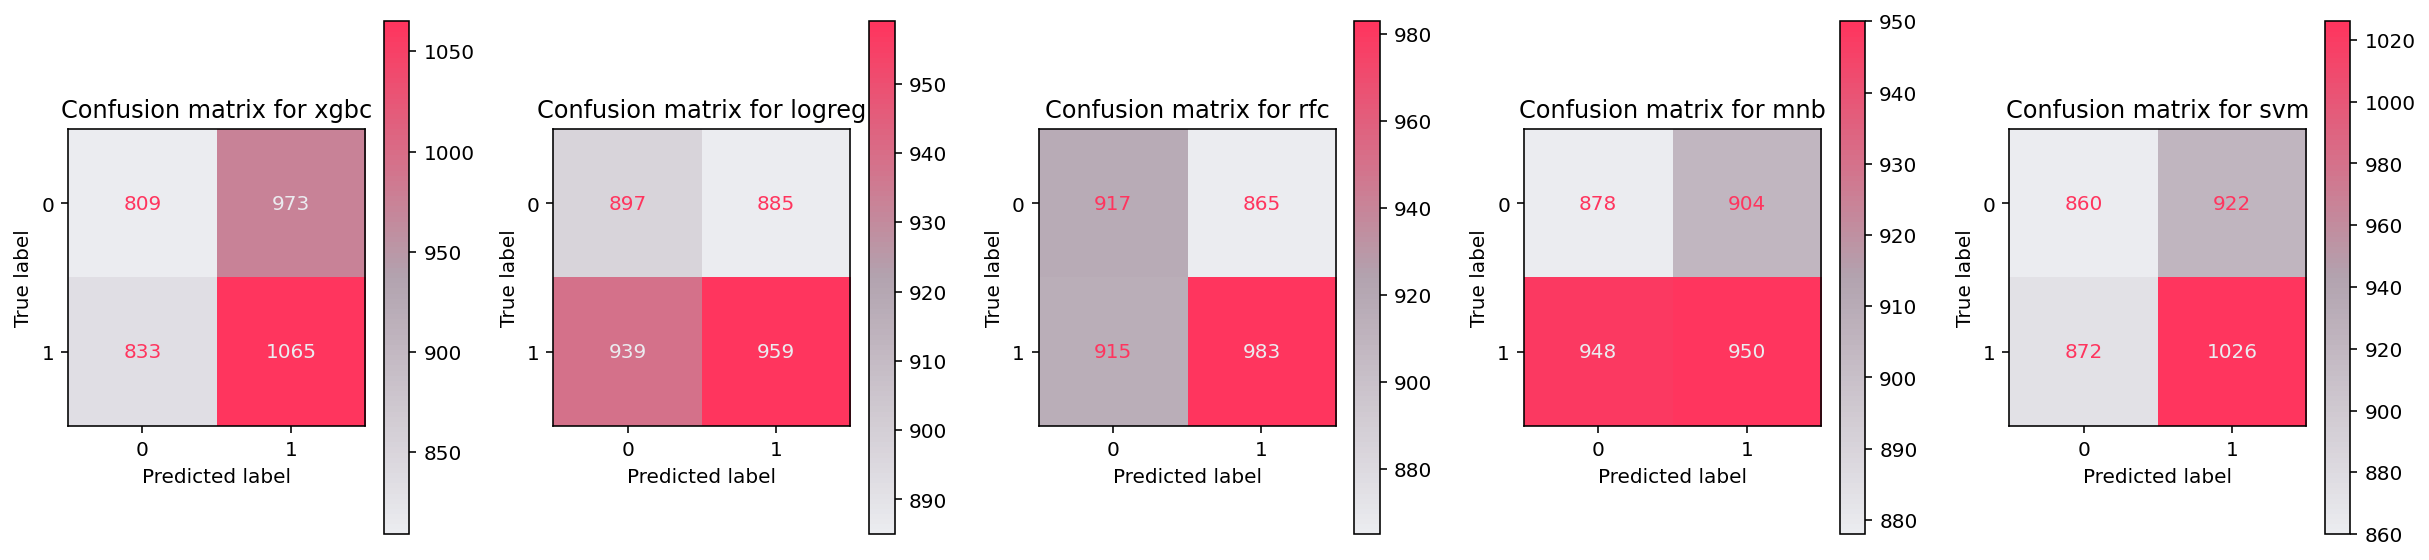

In [19]:
fig, axes = plt.subplots(1,5, figsize=(17,4))
for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(mod_est[model], X_test_vec, y_test, ax=ax, cmap=pnkgry)
    ax.title.set_text(f"Confusion matrix for {model}")
plt.tight_layout()  
plt.show()

_Because sentiment scores seem to be confusing the models rather than improving their scores, next iterations don't use them._

### 4.2.3 Classifying using word vector and emoji count

In [20]:
X_cont = pd.concat([AW_posts_df['title_selftext'], AW_comments_df['body'], 
                    AM_posts_df['title_selftext'], AM_comments_df['body']], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext']),
                    np.zeros_like(AW_comments_df['body']),
                    np.ones_like(AM_posts_df['title_selftext']),
                    np.ones_like(AM_comments_df['body'])]).astype(int)

X_emo = pd.concat([AW_posts_df['emojis'], AW_comments_df['emojis'],AM_posts_df['emojis'],AM_comments_df['emojis']], axis = 0)

X = pd.concat([X_cont, X_emo], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X ,y , test_size = 0.1, random_state = 11)

tvec = TfidfVectorizer()
stan = StandardScaler()

X_train_vs = pd.concat([pd.DataFrame(tvec.fit_transform(X_train.iloc[:,0]).todense()), 
                        pd.DataFrame(stan.fit_transform(pd.DataFrame(X_train.iloc[:,1])).astype(int), columns = ['emo_ct'])], axis = 1)

X_test_vs = pd.concat([pd.DataFrame(tvec.transform(X_test.iloc[:,0]).todense()), 
                        pd.DataFrame(stan.transform(pd.DataFrame(X_test.iloc[:,1])).astype(int), columns = ['emo_ct'])], axis = 1)

In [ ]:
train_scores = []
test_scores = []
for model in models:
    trsc, tssc = fit_score_estimator(model, X_train_vs, y_train, X_test_vs, y_test)
    train_scores.append(trsc)
    test_scores.append(tssc)

Xgbc scored 0.8573 on train data and 0.7321 on test data.
Logreg scored 0.8378 on train data and 0.7303 on test data.
Rfc scored 0.9957 on train data and 0.7294 on test data.
Mnb scored 0.8476 on train data and 0.7097 on test data.


In [ ]:
train_test_scores = pd.DataFrame(np.array([train_scores, test_scores]), columns = models, index = ['train_score', 'test_score'])
train_test_scores

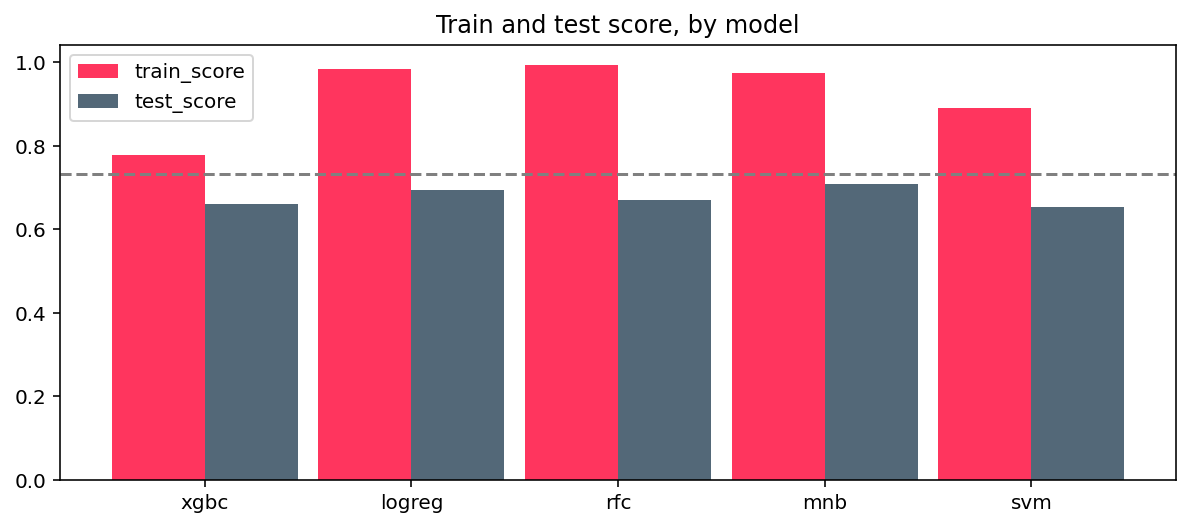

In [28]:
train_test_scores.T.plot(kind = 'bar', color = ['#ff355e','#536878'], 
                         title = 'Train and test score, by model', width = 0.9, figsize = (10, 4), rot = 0)
plt.axhline(0.732, ls = '--', color = 'grey');
plt.savefig('../visualizations/scores_bar_text_emoct.png')

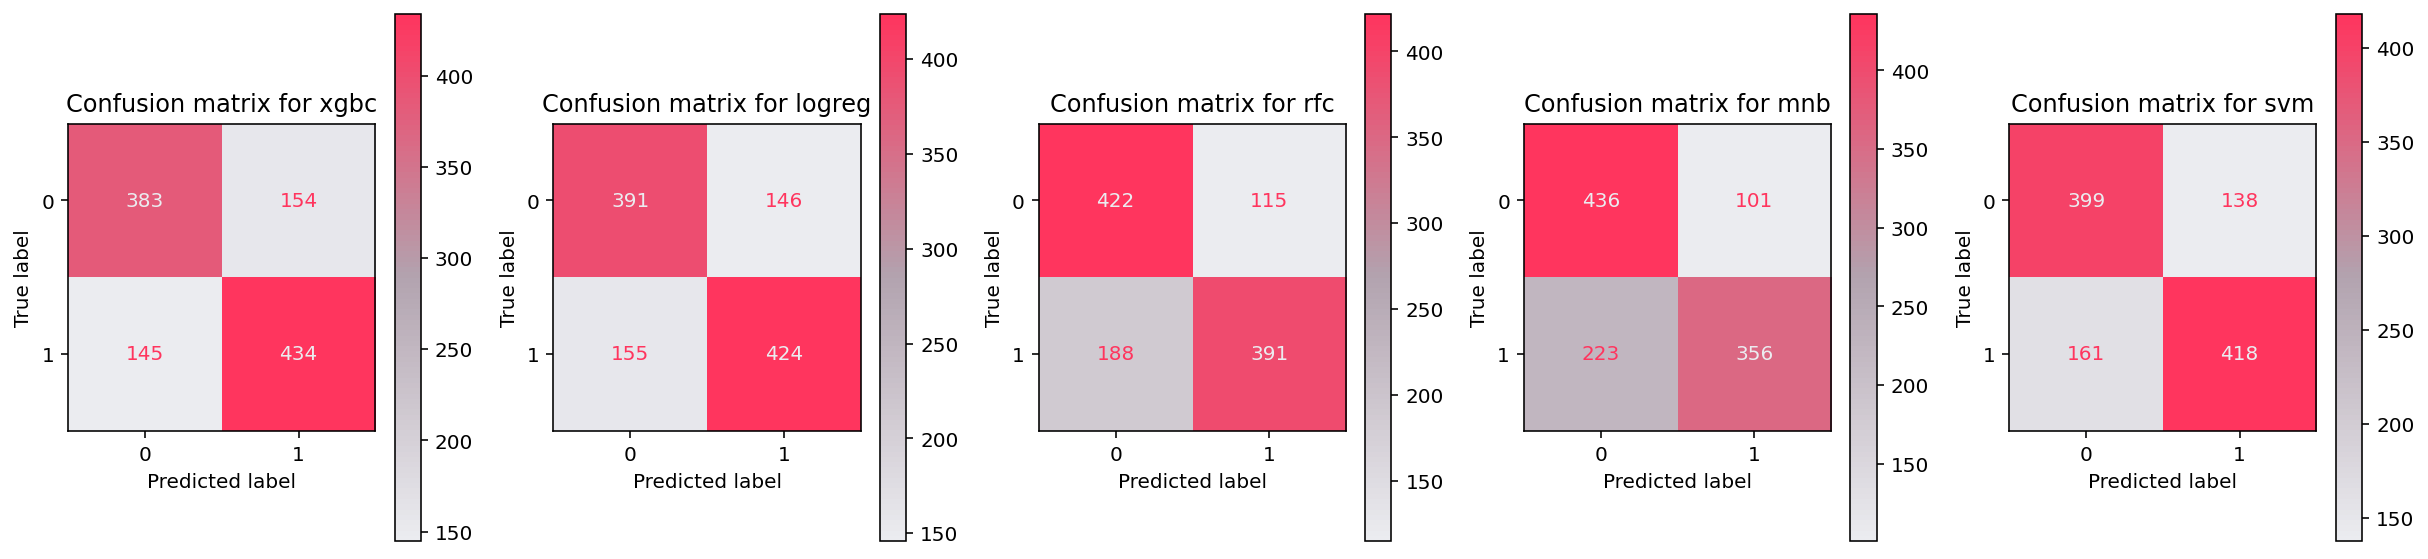

In [1217]:
fig, axes = plt.subplots(1,5, figsize=(17,4))
for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(mod_est[model], X_test_vs, y_test, ax=ax, cmap=pnkgry)
    ax.title.set_text(f"Confusion matrix for {model}")
plt.tight_layout()  
plt.show()

### 4.2.4 Classifying using word vector, sentiment scores, emoji count, as well as emojis as discrete features

In [11]:
X= pd.concat([AW_posts_df['title_selftext'], AW_comments_df['body'], 
                    AM_posts_df['title_selftext'], AM_comments_df['body']], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext']),
                    np.zeros_like(AW_comments_df['body']),
                    np.ones_like(AM_posts_df['title_selftext']),
                    np.ones_like(AM_comments_df['body'])]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 11)

emovec = CountVectorizer(token_pattern=emoji.get_emoji_regexp())
tvec = TfidfVectorizer()
X_train_vec = pd.DataFrame(tvec.fit_transform(X_train).todense())
X_train_emo_vec = pd.merge(X_train_vec,  pd.DataFrame(emovec.fit_transform(X_train).todense()),
                            how = 'inner', left_index= True, right_index= True)

X_test_vec = pd.DataFrame(tvec.transform(X_test).todense())
X_test_emo_vec = pd.merge(X_test_vec,  pd.DataFrame(emovec.transform(X_test).todense()),
                            how = 'inner', left_index= True, right_index= True)

In [ ]:
train_scores = []
test_scores = []
for model in models:
    trsc, tssc = fit_score_estimator(model, X_train_emo_vec, y_train, X_test_emo_vec, y_test)
    train_scores.append(trsc)
    test_scores.append(tssc)

Xgbc scored 0.8584 on train data and 0.7321 on test data.
Logreg scored 0.8393 on train data and 0.7312 on test data.
Rfc scored 0.996 on train data and 0.7079 on test data.
Mnb scored 0.8465 on train data and 0.7124 on test data.


In [1087]:
train_test_scores = pd.DataFrame(np.array([train_scores, test_scores]), columns = models, index = ['train_score', 'test_score'])
train_test_scores

,xgbc,logreg,rfc,mnb,svm
train_score,0.858396,0.839263,0.996014,0.846537,0.953662
test_score,0.732079,0.731183,0.734767,0.712366,0.741935


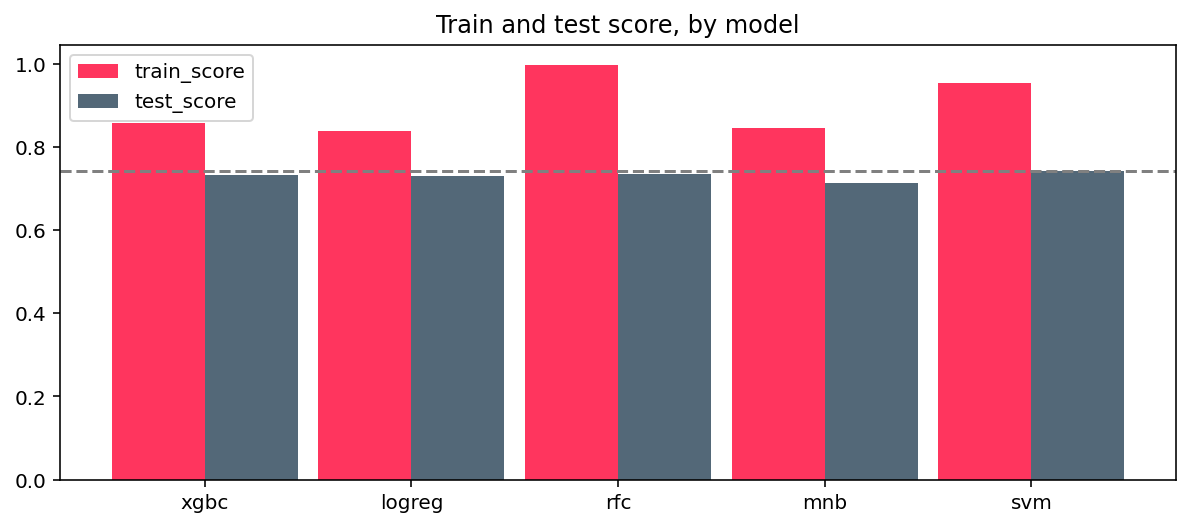

In [1090]:
train_test_scores.T.plot(kind = 'bar', color = ['#ff355e','#536878'], 
                         title = 'Train and test score, by model', width = 0.9, figsize = (10, 4), rot = 0)
plt.axhline(0.7419, ls = '--', color = 'grey');
plt.savefig('../visualizations/scores_bar_text_emoji.png')

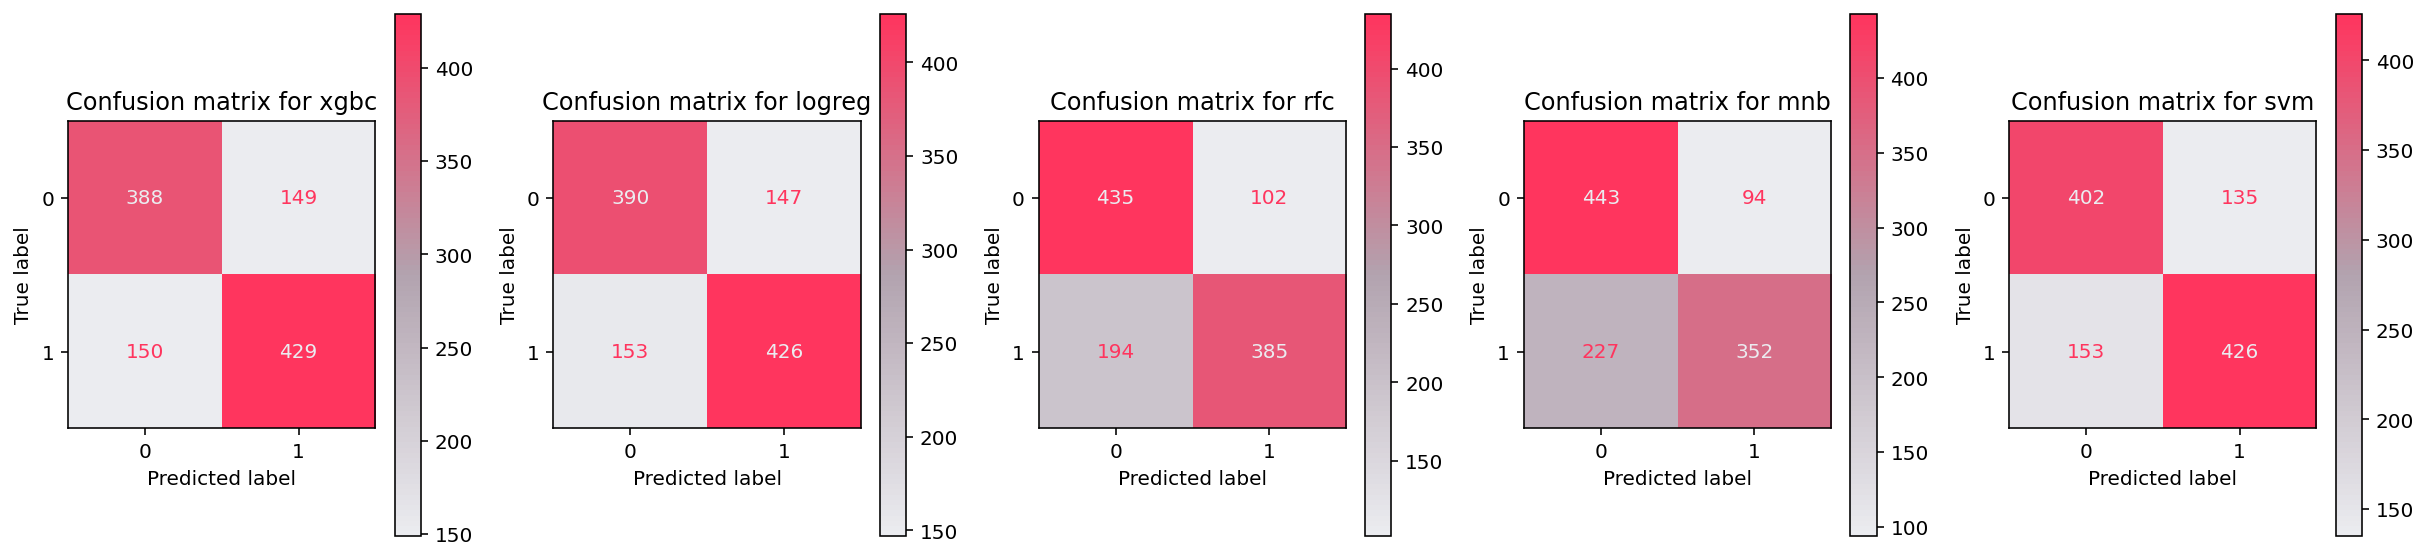

In [1092]:
fig, axes = plt.subplots(1,5, figsize=(17,4))
for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(mod_est[model], X_test_emo_vec, y_test, ax=ax, cmap=pnkgry)
    ax.title.set_text(f"Confusion matrix for {model}")
plt.tight_layout()  
plt.show()

#### 4.2.5 Optimization of the best estimators so far using GridSearch

_In reality, gridsearch on vectors combined of both words and emoji came to a gridlock, so the code below uses previously pickled estimators applied to just word data._

Note, also, that in order to not have to re-run the time- and computing-intense gridsearch fits, as well as to be able to run them on Google Colab / in Sagemaker, I resorted to pickling, and so instead of fitting the models below, I am loading pre-pickled the estimators, with the code used for their fitting marked as comments.

In [11]:
rfc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier())])

xgbc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('xgbc', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'))])

svm_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())])

In [12]:
rfc_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    'rfc__max_features': [None, 10_000], 
   'rfc__min_samples_leaf': [1,5],
   'rfc__n_estimators': [100, 125]}

xgbc_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    'xgbc__gamma': np.linspace(0,1,3),
    'xgbc__max_depth': [3,4,5],
    'xgbc__reg_lambda': np.logspace(0,1,5)}
    
svm_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    'svm__C': np.linspace(0.0001, 5, 20),
    'svm__degree':[1, 2, 3, 4]}

In [13]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.1, random_state = 11)

##### 4.2.5.1 Support Machine Vector

In [ ]:
#svm_pipe_gs = GridSearchCV(svm_pipe, svm_params, n_jobs = 5, cv = 5, verbose = 1)
#svm_pipe_gs.fit(train_X,train_y)
#pickle.dump(svm_pipe_gs.best_estimator_, open('../pickles/svm_pipe_gs.p', 'wb'))

In [14]:
svm_pipe_gs_best_estimator = pickle.load(open('../pickles/svm_pipe_gs.p', 'rb'))

##### 4.2.5.2 Random Forest Classifier

In [499]:
#rfc_pipe_gs = GridSearchCV(rfc_pipe, rfc_params, n_jobs = 5, cv = 5, verbose = 2, return_train_score=True)
#rfc_pipe_gs.fit(train_X, train_y) fit, pickled, and retrieved below
#pickle.dump(rfc_pipe_gs_best_estimator, open('./pickles/rfc_pipe_gs.p', 'wb'))

In [15]:
rfc_pipe_gs_best_estimator = pickle.load(open('../pickles/rfc_pipe_gs.p', 'rb'))

##### 4.2.5.3 XGBoost Classifier

In [ ]:
# xgbc_pipe_gs = GridSearchCV(xgbc_pipe, xgbc_params, n_jobs = 5, cv = 5, verbose = 1)
# xgbc_pipe_gs.fit(train_X,train_y)

#pickle.dump(xgbc_pipe_gs.best_estimator_, open('../pickles/xgbc_pipe_gs.p', 'wb'))

In [16]:
xgbc_pipe_gs_best_estimator = pickle.load(open('../pickles/xgbc_pipe_gs.p', 'rb'))

#### 4.2.6 "Bruteforce" Voting Classifier using three models with optimized parameters

In [17]:
bruteforce_vote = pd.DataFrame(np.array([svm_pipe_gs_best_estimator.predict(X),rfc_pipe_gs_best_estimator.predict(X), 
                                        xgbc_pipe_gs_best_estimator.predict(X)]).T, 
                                        columns = ['svm', 'rfc', 'xgbc'])
bruteforce_vote['sum_votes'] = bruteforce_vote['svm'] + bruteforce_vote['rfc'] + bruteforce_vote['xgbc']
bruteforce_vote['prediction'] = bruteforce_vote['sum_votes'].apply(lambda x: 1 if x > 1.5 else 0)

In [18]:
accuracy_score(y, bruteforce_vote['prediction']) 

0.8822527127611873

This score is overstating results because it includes both the training data and test data. This is not the case with the sklearn classifiers in 4.2.7 and 4.2.8.

In [19]:
pickle.dump(bruteforce_vote, open('../pickles/bf_v.p', 'wb'))

#### 4.2.7 sklearn Voting classifier using three models with optimized parameters

In [20]:
vote = VotingClassifier([('SVM', svm_pipe_gs_best_estimator), 
                          ('RFC', rfc_pipe_gs_best_estimator),
                          ('XGBC', xgbc_pipe_gs_best_estimator)])
vote.fit(train_X, train_y)
vote.score(train_X, train_y)

0.9932237169905331

In [22]:
vote.score(test_X, test_y)

0.7589605734767025

In [23]:
pickle.dump(vote, open('../pickles/vote.p', 'wb'))

#### 4.2.8 Randomized Optimization of the sklearn Voting Classifier

In [25]:
vote_gs = VotingClassifier([('svm', svm_pipe), 
                          ('rfc', rfc_pipe), 
                        ('xgbc', xgbc_pipe)])

In [26]:
vote_gs_params = {'svm__svm__C': np.array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
                                           1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
                                           2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
                                           3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ]),
               
                'svm__svm__degree': [1, 2, 3, 4],
                'svm__tvec__max_df': [0.8, 0.9, 1],
                'svm__tvec__ngram_range': [(1, 1), (1, 2)],
                'svm__tvec__stop_words': [None, 'english'],
                'svm__tvec__use_idf': [True, False],
                
                'rfc__rfc__max_features': [None, 10000, 5000],
                'rfc__rfc__min_samples_leaf': [1, 5, 10],
                'rfc__rfc__n_estimators': [5, 10, 15],
                'rfc__tvec__max_df': [0.8, 0.9, 1],
                'rfc__tvec__ngram_range': [(1, 1), (1, 2)],
                'rfc__tvec__stop_words': [None, 'english'],
                'rfc__tvec__use_idf': [True, False],
              
                'xgbc__tvec__max_df': [0.8, 0.9, 1],
                'xgbc__tvec__ngram_range': [(1, 1), (1, 2)],
                'xgbc__tvec__stop_words': [None, 'english'],
                'xgbc__tvec__use_idf': [True, False],
                'xgbc__xgbc__gamma': np.array([0. , 0.5, 1. ]),
                'xgbc__xgbc__max_depth': [3, 4, 5],
                'xgbc__xgbc__reg_lambda': np.array([ 1.        ,  1.77827941,  3.16227766,  5.62341325, 10.        ])
                 }

In [27]:
vote_gs_randopt = RandomizedSearchCV(vote_gs, vote_gs_params, verbose = 1, n_jobs=5)

In [32]:
#vote_gs_randopt.fit(train_X, train_y)

In [ ]:
#vote_gs_randopt.best_score_ 
# the optimization is taking forever to run at 11:40 pm on Friday but when I executed it in the past few days, it retur

In [2]:
# best_score = 0.6816680322250859
# for i in range(10):
#     vote_gs_randopt.fit(train_X,train_y)
#     if vote_gs_randopt.best_score_ > best_score:
#         best_score = vote_gs_randopt.best_score_
#         best_est = vote_gs_randopt.best_estimator_
#         print(best_score)

In [ ]:
# accuracy_score(best_est, test_X, test_y)

In [ ]:
#pickle.dump(best_est, open('../pickles/vote_randopt.p', 'wb')

#### Backup: Two other estimators with optimized hyperparameters

In [1]:
#logreg_pipe_gs = GridSearchCV(logreg_pipe, logreg_params, n_jobs = 5, cv = 5, verbose = 1)
#logreg_pipe_gs.fit(train_X,train_y) 
#the model was fitted and pickled below to avoid unnecessary recomputing
#pickle.dump(logreg_pipe_gs.best_estimator_, open('../pickles/logreg_pipe_gs.p', 'wb'))

In [ ]:
#mnb_pipe_gs = GridSearchCV(mnb_pipe, mnb_params, n_jobs = 5, cv = 5, verbose = 1)
#mnb_pipe_gs.fit(train_X,train_y) 
#the model was fitted and pickled below to avoid unnecessary recomputing
#pickle.dump(mnb_pipe_gs.best_estimator_, open('../pickles/mnb_pipe_gs.p', 'wb'))

In [22]:
logreg_pipe_gs_best_estimator = pickle.load(open('../pickles/logreg_pipe_gs.p', 'rb'))
mnb_pipe_gs_best_estimator = pickle.load(open('../pickles/mnb_pipe_gs.p', 'rb'))